<a href="https://colab.research.google.com/github/electrolabopen/pytorch-pytorchligtning/blob/main/transfer_learning_guardar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=7a78fe74dcca1918ceaae10be8a1d5929d66b4506ec616cc01bb818b14db09b2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget 

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [ ]:
import os 

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: dandelion. Imágenes: 1055
Categoría: rose. Imágenes: 784
Categoría: daisy. Imágenes: 769
Categoría: sunflower. Imágenes: 734
Categoría: tulip. Imágenes: 984


Podemos visualizar algunas imágenes en el dataset.

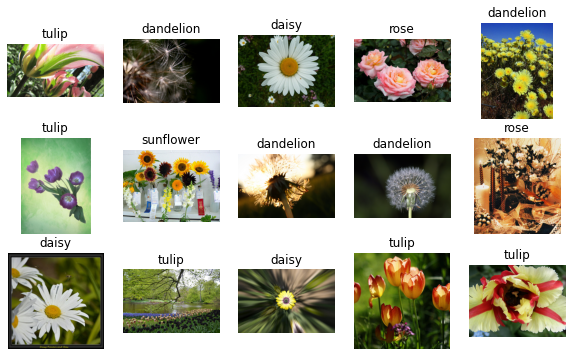

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

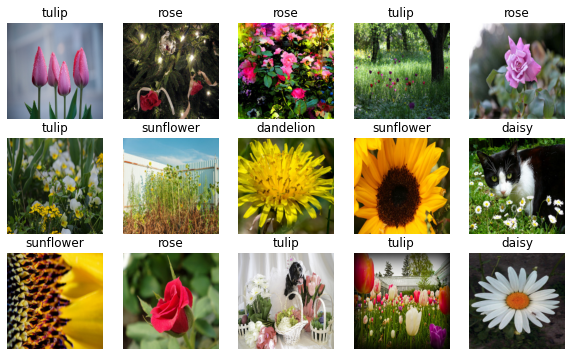

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [ ]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [ ]:
model = Model()
fit(model, dataloader, epochs=15)

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/15 loss 1.36264 val_loss 2.03723 acc 0.42443 val_acc 0.20123


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/15 loss 1.15250 val_loss 2.85700 acc 0.53551 val_acc 0.32493


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/15 loss 1.04770 val_loss 3.15351 acc 0.58892 val_acc 0.31205


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/15 loss 0.99460 val_loss 16.78234 acc 0.60057 val_acc 0.24260


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/15 loss 0.93331 val_loss 10.53547 acc 0.63807 val_acc 0.17592


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6/15 loss 0.86147 val_loss 2.36146 acc 0.67188 val_acc 0.47438


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7/15 loss 0.81280 val_loss 1.80742 acc 0.68892 val_acc 0.41673


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8/15 loss 0.78062 val_loss 2.67166 acc 0.70568 val_acc 0.31853


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9/15 loss 0.73307 val_loss 1.12121 acc 0.71989 val_acc 0.59222


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/15 loss 0.68384 val_loss 3.73623 acc 0.74517 val_acc 0.35513


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11/15 loss 0.67546 val_loss 6.56007 acc 0.75369 val_acc 0.31346


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12/15 loss 0.63357 val_loss 2.21841 acc 0.76562 val_acc 0.47926


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13/15 loss 0.60722 val_loss 4.43421 acc 0.77415 val_acc 0.35930


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14/15 loss 0.58012 val_loss 4.92978 acc 0.78295 val_acc 0.32911


val_loss 1.76786 val_acc 0.54515: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

Epoch 15/15 loss 0.53730 val_loss 1.76786 acc 0.79915 val_acc 0.54515


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/5 loss 1.04821 val_loss 1.09218 acc 0.63920 val_acc 0.52180


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/5 loss 0.67580 val_loss 0.73210 acc 0.79403 val_acc 0.74291


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/5 loss 0.53871 val_loss 0.74415 acc 0.83636 val_acc 0.70499


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/5 loss 0.47524 val_loss 0.51437 acc 0.85568 val_acc 0.80037


val_loss 0.56448 val_acc 0.80685: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

Epoch 5/5 loss 0.44823 val_loss 0.56448 acc 0.86278 val_acc 0.80685


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [ ]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/5 loss 0.77915 val_loss 0.67456 acc 0.73920 val_acc 0.72897


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/5 loss 0.35181 val_loss 0.39898 acc 0.89489 val_acc 0.87310


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/5 loss 0.24432 val_loss 0.36019 acc 0.93011 val_acc 0.86423


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/5 loss 0.18614 val_loss 0.35838 acc 0.94972 val_acc 0.87399


val_loss 0.49310 val_acc 0.81689: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

Epoch 5/5 loss 0.17452 val_loss 0.49310 acc 0.95312 val_acc 0.81689


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/5 loss 1.07199 val_loss 0.95532 acc 0.63835 val_acc 0.61034


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/5 loss 0.66797 val_loss 1.50460 acc 0.80398 val_acc 0.43078


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/5 loss 0.54656 val_loss 0.64352 acc 0.83920 val_acc 0.74967


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/5 loss 0.47885 val_loss 0.57718 acc 0.85455 val_acc 0.77471


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/5 loss 0.44897 val_loss 0.66405 acc 0.84915 val_acc 0.72479


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/5 loss 0.60137 val_loss 0.57783 acc 0.75710 val_acc 0.76502


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/5 loss 0.53505 val_loss 0.52251 acc 0.78523 val_acc 0.79814


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/5 loss 0.46650 val_loss 0.47716 acc 0.83750 val_acc 0.81822


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/5 loss 0.46187 val_loss 0.45321 acc 0.84233 val_acc 0.82666


val_loss 0.44096 val_acc 0.84415: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

Epoch 5/5 loss 0.45014 val_loss 0.44096 acc 0.85256 val_acc 0.84415


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.

## Para guardar y exportar un Modelo entrenado

In [ ]:
PATH = './checkpoint.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

Model(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Evaluamos el modelo

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    model.to(device)
    bar = tqdm(dataloader['test'])
    acc = []
    with torch.no_grad():
        for batch in bar:
            x,y = batch
            x,y = x.to(device), y.to(device)
            y_hat = model(x)
            acc.append((y == torch.argmax(y_hat, axis=1)).sum().item() / len(y))
            bar.set_description(f"acc {np.mean(acc):.5f}")
  

In [ ]:
evaluate(model, dataloader)




  0%|          | 0/4 [00:00<?, ?it/s]


acc 0.82812:   0%|          | 0/4 [00:01<?, ?it/s]


acc 0.82812:  25%|██▌       | 1/4 [00:01<00:03,  1.27s/it]


acc 0.83594:  25%|██▌       | 1/4 [00:02<00:03,  1.27s/it]


acc 0.83594:  50%|█████     | 2/4 [00:02<00:02,  1.26s/it]


acc 0.84375:  50%|█████     | 2/4 [00:03<00:02,  1.26s/it]


acc 0.84375:  75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]


acc 0.84415:  75%|███████▌  | 3/4 [00:04<00:01,  1.23s/it]


acc 0.84415: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


## Otra forma de guardar el modelo seria asi: 

In [ ]:
torch.save(model, 'model.pt')

In [ ]:
model = torch.load('model.pt')
model.eval()

Model(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
evaluate(model, dataloader)




  0%|          | 0/4 [00:00<?, ?it/s]


acc 0.82812:   0%|          | 0/4 [00:01<?, ?it/s]


acc 0.82812:  25%|██▌       | 1/4 [00:01<00:03,  1.26s/it]


acc 0.83594:  25%|██▌       | 1/4 [00:02<00:03,  1.26s/it]


acc 0.83594:  50%|█████     | 2/4 [00:02<00:02,  1.23s/it]


acc 0.84375:  50%|█████     | 2/4 [00:03<00:02,  1.23s/it]


acc 0.84375:  75%|███████▌  | 3/4 [00:03<00:01,  1.21s/it]


acc 0.84415:  75%|███████▌  | 3/4 [00:04<00:01,  1.21s/it]


acc 0.84415: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
